In [ ]:

! pip install hazm
from hazm import *
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score
import math
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import json
from copy import deepcopy
import numpy as np
import random
import re
import string
import codecs
from shutil import copyfile
random.seed(12345)
label_encoder = preprocessing.LabelEncoder()

     |████████████████████████████████| 316 kB 11.8 MB/s 
     |████████████████████████████████| 1.4 MB 44.3 MB/s 
     |████████████████████████████████| 233 kB 47.7 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394487 sha256=abd63b603ce4f4825295986ec2a3be73da1b1730c857bf8e24cd17d43e61338f
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=153879 sha256=baca13afcd98cf40e8a3122d2c77434658d0c68a9ca9a72c8f14b8245b6a7c0e
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
# downloading data
# downloading persian stopwords


Downloading...
From: https://drive.google.com/uc?id=1KpJCXTkuy1NLR5MgXsoYfBsv_OnwJqIF
To: /content/AI_NEWS.csv
100% 16.8M/16.8M [00:00<00:00, 152MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qiq2I8EdTcgn2Wc03XqucUcMhBdVhEre
To: /content/stopwords.txt
100% 3.66k/3.66k [00:00<00:00, 4.95MB/s]


In [ ]:
news = pd.read_csv('AI_NEWS.csv')
news.head(10)

,Unnamed: 0,index,title,text,category,keywords,source_name,data,tag
0,0,2000,لیگ قهرمانان آسیا| استقلال ایران 3 - الشرطه عر...,NaN,ورزشی,لیگ قهرمانان آسیا| استقلال ایران - الشرطه عراق...,جماران,1463620,غیر مهم
1,1,2001,سویه لامبدا؛ خیلی دور، خیلی نزدیک!/ هر آنچه که...,NaN,اقتصادی,NaN,آنا,3041187,غیر مهم
2,2,2002,افزایش تحرکات هیات ها در مذاکرات وین؛ تحولاتی ...,به گزارش خبرنگار ایرنا از وین، آهنگ رفت و آمد ...,بین الملل,"وین,کمیسیون مشترک برجام,علی باقری,مذاکرات برای...",ایرنا,4132788,مهم
3,3,2003,ناکارآمدی بازرگانی محصولات کشاورزی ناشی از ناک...,به گزارش خبرگزاری فارس از تبریز، اکبر فتحی در ...,اقتصادی,"کشاورزی,آذربایجان شرقی,کشاورزان,محصولات,کشت فر...",خبرگزاری فارس,3652101,غیر مهم
4,4,2004,طالبان: بدنبال روابط خوب با همه کشورها از جمله...,به گزارش دفتر منطقه ای خبرگزاری تسنیم، «ذبیح ا...,بین الملل,NaN,خبرگزاری تسنیم,3846298,غیر مهم
5,5,2005,ابهامات عرضه خودرو در بورس,به گزارش ایسنا، کمیسیون صنایع مجلس عرضه خودرو ...,اقتصادی,"عرضه خودرو در بورس کالا,",ایسنا,1516522,غیر مهم
6,6,2006,حذف ارز ۴۲۰۰ تومانی فشاری به اقشار ضعیف وارد ن...,مصطفی طاهری عضو کمیسیون صنایع و معادن مجلس شور...,اقتصادی,NaN,خبرگزاری تسنیم,4319697,مهم
7,7,2007,گوگل از یک آسیب پذیری خطرناک در ویندوز پرده بر...,تیم امنیتی پروژه Zero گوگل از یک آسیب پذیری خط...,فناوری و ارتباطات,NaN,دیجیاتو,143666,غیر مهم
8,8,2008,تولید اولین واکسن ایرانی آبزیان به همت یک شرکت...,سرویس جامعه جوان آنلاین: دکتر مریم ابراهیمی تا...,علمی و پزشکی,NaN,روزنامه جوان آنلاین,1437136,غیر مهم
9,9,2009,قیمت جهانی نفت امروز ۱۴۰۰/۰۱/۲۷|برنت به مرز ۶۷...,به گزارش خبرگزاری تسنیم به نقل از رویترز، در ح...,اقتصادی,NaN,خبرگزاری تسنیم,1425854,غیر مهم


In [ ]:
news["source_name"].value_counts()[0:12]

ایرنا               492
خبرگزاری فارس       478
ایسنا               413
خبرگزاری تسنیم      291
خبرگزاری مهر        232
خبرگزاری برنا       180
باشگاه خبرنگاران    149
ایلنا               148
ورزش 3              140
شبستان              132
حوزه                 87
دنیای اقتصاد         83
Name: source_name, dtype: int64

In [ ]:
khabar_gozari_word={
    "hozeh": [" خبرگزاری حوزه",
" خبرگزاری «حوزه»"],
    "fars":[" گروه بین الملل خبرگزاری فارس",
            "خبرگزاری فارس"],
      "isna":["ایسنا"],
      "tasnim":["تسنیم"],
      "mehr" : ["خبرگزاری مهر","خبرنگار مهر"],
      "borna":["برنا ","برنا،"],
      "bashgah khabarnegaran":["باشگاه خبرنگاران"],
      "ilna":["ایلنا"],
      "varzesh3":["ورزش سه",
                  'گزارش "ورزش سه"'],
      "shabestan":["خبرگزاری شبستان","شبستان"]     
}
all_pattern = []
for index in khabar_gozari_word:
  for item in khabar_gozari_word[index]:
      all_pattern.append(item)

In [ ]:
class Preprocessing:

  @staticmethod
  def remove_punctuations(text):
    new_text = []
    for l in text:
      if l not in string.punctuation + '\u00AB' + '\u00BB' + '\u060C' + '\u061B' + '\u061F':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)
  
  @staticmethod
  def remove_numbers(text):
    new_text = []
    for l in text:
      if l not in '0123456789۰۱۲۳۴۵۶۷۸۹':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)

  @staticmethod
  def remove_stopwords(text):
    normalizer = Normalizer()
    stopwords = [normalizer.normalize(x.strip()) for x in codecs.open('stopwords.txt','r','utf-8').readlines()]
    tokens = word_tokenize(text)
    new_text = []
    for token in tokens:
      if token not in stopwords:
        new_text.append(token)
      else:
        new_text.append(' ')
    return ' '.join(new_text)

  @staticmethod
  def remove_extra_space(text):
    new_text = re.sub(r'\s+',' ',text)
    return new_text

In [ ]:
# a class to hold our data structure
class Data:
  def __init__(self, data, preprocessing=False):
    self.title = data['title']
    self.text = data['text']
    self.category = data['category']
    self.label = label_encoder.transform([data['tag']])[0]

# label encoder
all_labels = ['مهم','غیر مهم']
label_encoder.fit(all_labels)
classes = label_encoder.classes_

# convert raw data into Data objects
news_data = []
for index, data in news.iterrows():
  news_data.append(Data(data, True))

In [ ]:
def split_data(data, portions=[.6,.2,.2]):

  random.shuffle(data)
  data_len = len(data)
  train_data = data[:int(portions[0] * data_len)]
  eval_data = data[int(portions[0] * data_len):int((portions[0] + portions[1]) * data_len)]
  test_data = data[int((portions[0] + portions[1]) * data_len):]
  return train_data, eval_data, test_data

In [ ]:
# a function to get a portion of data with acquired preprocessings
def get_data(dataset, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True}):

  random.shuffle(dataset)
  new_dataset = []

  # applying preprocessings on train data
  for i, data in enumerate(tqdm(dataset)):
    if str(data.text) == 'nan':
      continue
    if preprocess['remove_stopwords'] == True:
      dataset[i].text = Preprocessing.remove_stopwords(data.text)
    if preprocess['remove_punctuations'] == True:
      dataset[i].text = Preprocessing.remove_punctuations(data.text)
    if preprocess['remove_numbers'] == True:
      dataset[i].text = Preprocessing.remove_numbers(data.text)
    dataset[i].text = Preprocessing.remove_extra_space(data.text)
    new_dataset.append(dataset[i])

  return split_data(new_dataset)

In [ ]:
train_data, eval_data, test_data = get_data(news_data, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True})

100%|██████████| 4000/4000 [01:21<00:00, 48.95it/s]


In [ ]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

In [ ]:
train_y = []
val_y = []
test_y = []

train_X = []
val_X = []
val_X = []

train_X_clean = []
eval_X_clean = []
test_X_clean = []


def return_data_set(data_arr,all_pattern):
  ptt ="("+"|".join(all_pattern)+")"
  X,y,X_clean  = [],[],[]
  for j,news in enumerate(data_arr):
      y.append(news.label)
      X.append(news.title + news.text)
      all_sr = re.sub(ptt, '', news.title + news.text)
      X_clean.append(all_sr)
  return X,y,X_clean


def to_seq(X,tokenizer):
  X_Seq = []
  for abs_ in X:
    X_Seq.append(tokenizer.texts_to_sequences([abs_])[0])
  return X_Seq

############################################

train_X  , train_y , train_X_clean = return_data_set(train_data,all_pattern)
val_X    , val_y   , eval_X_clean = return_data_set(eval_data,all_pattern)
test_X    , test_y  , test_X_clean = return_data_set(test_data,all_pattern)
#############################################

train_y  = to_categorical(train_y, num_classes=None) 
val_y  = to_categorical(val_y, num_classes=None)   
test_y  = to_categorical(test_y, num_classes=None)   
#############################################

vocab_selection = 10000
tokenizer = Tokenizer(num_words=vocab_selection,oov_token='N')
tokenizer.fit_on_texts(train_X)
pickle.dump(tokenizer, open('token_nn.pkl', 'wb'))




sequence_data_train = to_seq(train_X,tokenizer)
sequence_data_val = to_seq(val_X,tokenizer)
sequence_data_test = to_seq(test_X,tokenizer)
sequence_data_train_clean = to_seq(train_X_clean,tokenizer)
sequence_data_eval_clean = to_seq(eval_X_clean,tokenizer)
sequence_data_test_clean = to_seq(test_X_clean,tokenizer)



In [ ]:
sequence_data_train = tf.keras.preprocessing.sequence.pad_sequences(sequence_data_train, maxlen=500, dtype='int32', padding='pre',truncating='pre', value=0.0)
sequence_data_val = tf.keras.preprocessing.sequence.pad_sequences(sequence_data_val, maxlen=500, dtype='int32', padding='pre',truncating='pre', value=0.0)
sequence_data_test = tf.keras.preprocessing.sequence.pad_sequences(sequence_data_test, maxlen=500, dtype='int32', padding='pre',truncating='pre', value=0.0)
sequence_data_test_clean = tf.keras.preprocessing.sequence.pad_sequences(sequence_data_test_clean, maxlen=500, dtype='int32', padding='pre',truncating='pre', value=0.0)
sequence_data_eval_clean = tf.keras.preprocessing.sequence.pad_sequences(sequence_data_eval_clean, maxlen=500, dtype='int32', padding='pre',truncating='pre', value=0.0)
sequence_data_train_clean = tf.keras.preprocessing.sequence.pad_sequences(sequence_data_train_clean, maxlen=500, dtype='int32', padding='pre',truncating='pre', value=0.0)

In [ ]:
MAX_LEN =500
MAX_FEATURES = 10000
EMBED_SIZE = 128
RNN_CELL_SIZE = 128

class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

############################ model ##########################################    
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(embedded_sequences)

state_h  = Concatenate()([forward_h, backward_h])
state_c  = Concatenate()([forward_c, backward_c])

context_vector1, attention_weights = Attention(25)(lstm, state_h)
context_vector2, attention_weights = Attention(25)(lstm, backward_h)
conc  = Concatenate()([context_vector1, context_vector2])

dense1      = Dense(512, activation="relu")(conc)
dropout1    = Dropout(0.8)(dense1)
dense2      = Dense(50, activation="relu")(dropout1)
dropout2    = Dropout(0.2)(dense2)
output      = Dense(2, activation="softmax")(dropout2)


model = keras.Model(inputs=sequence_input, outputs=output)
  

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 128)     1280000     ['input_1[0][0]']                
                                                                                                  
 bi_lstm_1 (Bidirectional)      [(None, 500, 256),   263168      ['embedding[0][0]']              
                                 (None, 128),                                                     
                                 (None, 128),                                                     
                                 (None, 128),                                                 

In [ ]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from sklearn.utils import compute_class_weight

METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    f1,
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR')
]

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=METRICS)
from sklearn.utils import class_weight
class_weights = [0.5,1] 
class_weights = {i : class_weights[i] for i in range(2)}                               
history = model.fit(sequence_data_train,train_y,batch_size=64,epochs=3,validation_data=(sequence_data_val, val_y), class_weight=class_weights)

Epoch 1/3
36/36 [==============================] - 16s 271ms/step - loss: 0.3380 - accuracy: 0.8512 - f1: 0.8515 - auc: 0.8577 - prc: 0.8190 - val_loss: 0.4483 - val_accuracy: 0.8679 - val_f1: 0.8676 - val_auc: 0.8979 - val_prc: 0.8848
Epoch 2/3
36/36 [==============================] - 8s 221ms/step - loss: 0.3049 - accuracy: 0.8639 - f1: 0.8622 - auc: 0.8918 - prc: 0.8734 - val_loss: 0.3680 - val_accuracy: 0.8679 - val_f1: 0.8676 - val_auc: 0.9230 - val_prc: 0.9078
Epoch 3/3
36/36 [==============================] - 8s 222ms/step - loss: 0.2044 - accuracy: 0.8868 - f1: 0.8875 - auc: 0.9551 - prc: 0.9518 - val_loss: 0.4052 - val_accuracy: 0.8032 - val_f1: 0.8027 - val_auc: 0.8972 - val_prc: 0.8910


In [ ]:
from sklearn.metrics import roc_auc_score
result_predict = model.predict(sequence_data_test)
all_pred = result_predict.argmax(axis =1)
test_y_inx = test_y.argmax(axis =1)
f1_macro = f1_score(test_y_inx,all_pred, average='macro')
f1_micro = f1_score(test_y_inx, all_pred, average='micro')
roc_auc  = roc_auc_score(test_y_inx, all_pred)
accuracy = accuracy_score(test_y_inx,all_pred)
recall = recall_score(test_y_inx, all_pred)
print(f'F1-macro {f1_macro}')
print(f'F1-micro {f1_micro}')
print(f'Accuracy {accuracy}')
print(f'recall {recall}')
print(f'ROC_AUC {roc_auc}')

F1-macro 0.6353742409092018
F1-micro 0.7912813738441216
Accuracy 0.7912813738441216
recall 0.4642857142857143
ROC_AUC 0.6561738648947951


In [ ]:
from keras.models import load_model

model.save_weights('model_weight.h5')
model_test = model


In [ ]:
model_test.load_weights('model_weight_nlp_proj.h5')

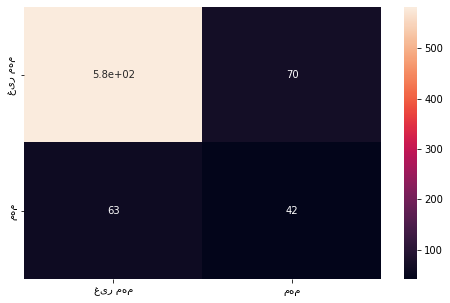

In [ ]:
c_mat = confusion_matrix(all_pred, test_y_inx)
df_cm = pd.DataFrame(c_mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (8,5))
sn.heatmap(df_cm, annot=True)

#clean press names from test data and evaluate model bias

In [ ]:
from sklearn.metrics import roc_auc_score
result_predict = model.predict(sequence_data_test_clean)
all_pred = result_predict.argmax(axis =1)
test_y_inx = test_y.argmax(axis =1)
f1_macro = f1_score(test_y_inx,all_pred, average='macro')
f1_micro = f1_score(test_y_inx, all_pred, average='micro')
roc_auc  = roc_auc_score(test_y_inx, all_pred)
accuracy = accuracy_score(test_y_inx,all_pred)
recall = recall_score(test_y_inx, all_pred)
print(f'F1-macro {f1_macro}')
print(f'F1-micro {f1_micro}')
print(f'Accuracy {accuracy}')
print(f'recall {recall}')
print(f'ROC_AUC {roc_auc}')

F1-macro 0.631954573391676
F1-micro 0.7899603698811096
Accuracy 0.7899603698811096
recall 0.45535714285714285
ROC_AUC 0.6517095791805093


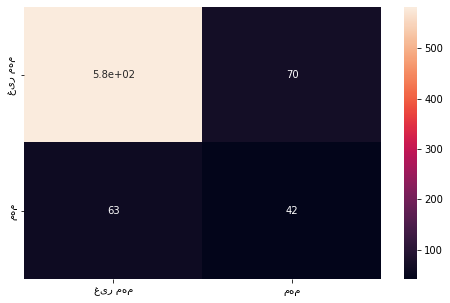

In [ ]:
c_mat = confusion_matrix(all_pred, test_y_inx)
df_cm = pd.DataFrame(c_mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (8,5))
sn.heatmap(df_cm, annot=True)